# GluonTS - Transfer Learning Approach (monthly) - 1/2

- Two datasets: A and B
- Dataset A: Dataset subsetted by frequency, i.e. `m4_monthly`
- Dataset B: Dataset subsetted by frequency and by domain, i.e. `m4_monthly_industry`
- Network A: Trained on dataset A
- Network B: Trained on dataset B
- Both networks are evaluated on dataset B. 

- Adjust epochs to account for different size of the datasets

Goal: Check TZ1: "Does the network learn from time series of the same domain or is it helpful to use time series from other domains?"

- Both networks are trained for ten trials (deepar) or three trials (deepstate)

Note that there are already results where a network is trained on `m4_frequency_domain` and evaluated on the same network.

In [22]:
!pip install mxnet=="1.4.1"

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [23]:
!pip install gluonts

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Imports



In [24]:
import gluonts
import mxnet

print(gluonts.__version__)
print(mxnet.__version__)

0.4.2
1.4.1


In [25]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar


In [26]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_daily_id', 'm4_hourly', 'm4_hourly_id', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_end032014', 'm4_monthly_end052015', 'm4_monthly_end092007', 'm4_monthly_finance', 'm4_monthly_id', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_micro_atm', 'm4_monthly_nonmicro_10975_seed42', 'm4_monthly_nonmicro_10975_seed43', 'm4_monthly_nonmicro_10975_seed44', 'm4_monthly_nonmicro_10975_seed45', 'm4_monthly_nonmicro_10975_seed46', 'm4_monthly_nonmicro_10975_seed47', 'm4_monthly_nonmicro_10975_seed48', 'm4_monthly_nonmicro_10975_seed49', 'm4_monthly_nonmicro_10975_seed50', 'm4_monthly_nonmicro_10975_seed51', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_finance', 'm4_quarterly_id', 'm4_quarterly_industry', 'm4_quarterly_macro', 'm4_quarterly_micro', 'm4_qu

In [27]:
dataset = get_dataset("m4_weekly", regenerate=False)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly.


### mv the data

Before moving on: Move the respective data according the required folder structure. In AWS:

- `mv [dataname] ../../.mxnet/gluon-ts/datasets/`

In [28]:
dataname_a = "m4_monthly_atm"
dataset_a = get_dataset(dataname_a, regenerate=False)
len(dataset_a.train)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_atm.


48000

In [29]:
dataname_b = "m4_monthly_industry"
dataset_b = get_dataset(dataname_b, regenerate=False)
len(dataset_b.train)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_industry.


10017

## Check the datasets 

### Dataset A


dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])
length train: 48000
length test: 48000

start:
 1750-01-31 00:00:00
target:
 [8000. 8350. 8570. 7700. 7080. 6520. 6070. 6650. 6830. 5710.]
feat_static_cat:
 [1]


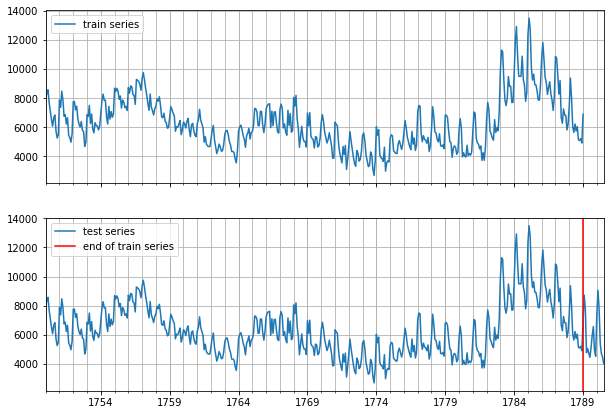

In [30]:
train_entry_a = next(iter(dataset_a.train))
test_entry_a = next(iter(dataset_a.test))

print(train_entry_a.keys())
print(test_entry_a.keys())
print("length train:", len(dataset_a.train))
print("length test:", len(dataset_a.test))


print("\nstart:\n",train_entry_a["start"])
print("target:\n", train_entry_a["target"][:10])
print("feat_static_cat:\n", train_entry_a["feat_static_cat"])

train_series_a = to_pandas(train_entry_a)
test_series_a = to_pandas(test_entry_a)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series_a.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series_a.plot(ax=ax[1])
ax[1].axvline(train_series_a.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

## Dataset B

dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])
length train: 10017
length test: 10017

start:
 1750-01-31 00:00:00
target:
 [8370. 8430. 7880. 8160. 8290. 8000. 8240. 7840. 8040. 7930.]
feat_static_cat:
 [1]


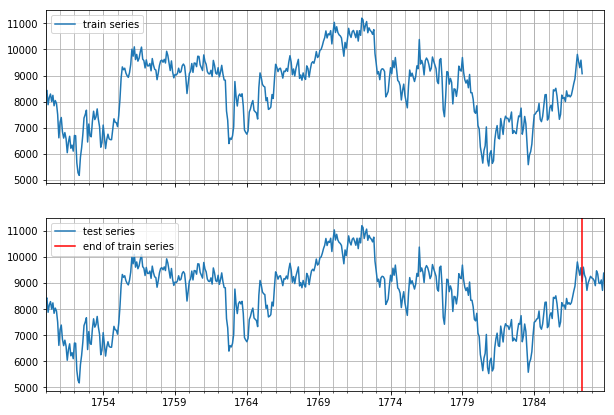

In [31]:
train_entry_b = next(iter(dataset_b.train))
test_entry_b = next(iter(dataset_b.test))

print(train_entry_b.keys())
print(test_entry_b.keys())
print("length train:", len(dataset_b.train))
print("length test:", len(dataset_b.test))

print("\nstart:\n",train_entry_b["start"])
print("target:\n", train_entry_b["target"][:10])
print("feat_static_cat:\n", train_entry_b["feat_static_cat"])

train_series_b = to_pandas(train_entry_b)
test_series_b = to_pandas(test_entry_b)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series_b.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series_b.plot(ax=ax[1])
ax[1].axvline(train_series_b.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

## Comparison of both datasets

- Compare whether both datasets have the same length


In [32]:
# Check length
print("Length test train:", len(dataset_a.train) == len(dataset_b.train))
print("Length test test:", len(dataset_a.test) == len(dataset_b.test))

# Check frequency
print("Frequency test:",(dataset_a.metadata.freq == dataset_b.metadata.freq))


Length test train: False
Length test test: False
Frequency test: True


## Modeling: DeepAR

In [33]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepar import DeepAREstimator

In [14]:
# A: dataset_a
# B: dataset_b
print(dataset_a)
print("\n", dataset_b)

TrainDatasets(metadata=MetaData(freq='M', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat', cardinality='48000')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=18), train=<gluonts.dataset.common.FileDataset object at 0x7f4ee0627ef0>, test=<gluonts.dataset.common.FileDataset object at 0x7f4edfd56be0>)

 TrainDatasets(metadata=MetaData(freq='M', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat', cardinality='10017')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=18), train=<gluonts.dataset.common.FileDataset object at 0x7f4edfd56400>, test=<gluonts.dataset.common.FileDataset object at 0x7f4edfd564a8>)


In [53]:
print(dataname_a)
print(dataname_b)

m4_monthly_atm
m4_monthly_industry


In [54]:
def deepar_train_eval(dataname_a, dataname_b, seed=42, epochs=100, num_batches=100):
    """
    Function that trains a network using data from dataset B and evaluates the trained network on dataset A.
    Dataset A is the dataset of interest for our analysis. 
    """    
    
    dataset_a = get_dataset(dataname_a, regenerate=False)
    dataset_b = get_dataset(dataname_b, regenerate=False)
    
    # Assert checks
    assert (dataset_a.metadata.freq == dataset_b.metadata.freq)
#     assert ( len(dataset_a.train)==len(dataset_b.train) )
#     assert ( len(dataset_a.test)==len(dataset_b.test))
    
    mx.random.seed(seed)
    np.random.seed(seed)

    # define trainer
    trainer=Trainer(
        ctx=mx.cpu(),
        epochs=epochs,
        num_batches_per_epoch=num_batches,
        learning_rate=1e-3,
    )

    estimator=DeepAREstimator(
        trainer=trainer,
        context_length=dataset_a.metadata.prediction_length,
        prediction_length=dataset_a.metadata.prediction_length,
        freq=dataset_a.metadata.freq,
        use_feat_static_cat=False,
    )
    
#     estimator = DeepAREstimator(
#         trainer=trainer,
#         cardinality= [
#             feat_static_cat.cardinality 
#             for feat_static_cat in dataset_a.metadata.feat_static_cat
#         ],
#         context_length=dataset_a.metadata.prediction_length,
#         prediction_length=dataset_a.metadata.prediction_length,
#         freq=dataset_a.metadata.freq,
#         use_feat_static_cat=True
#     )
    
    # predictor trained on dataset_a, evaluated on dataset_b
    predictor_a=estimator.train(training_data=dataset_a.train)
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset_b.test, predictor=predictor_a, num_samples=100
    )
    
    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series = len(dataset_b.test))
    
    metrics=["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}
    
    output["seed"]=seed
    output["epochs"]=epochs
    output["num_batches"]=num_batches
    output["train data"]=dataname_a
    output["eval data"]=dataname_b
    
    df=pd.DataFrame([output])

    return df

    

## Subsets

In [55]:
print(dataname_a)
print(dataname_b)

m4_monthly_atm
m4_monthly_industry


## Study 1: `m4_monthly` vs. `m4_monthly_industry` trained network

### Run I.: Training: A, Eval: B

- 10 trials training a network on dataset a and evaluating network on data a

In [ ]:
# results = pd.DataFrame()

# for i in range(42,45):
#     print("Next seed:", i)
#     df = deepar_train_eval(dataname_a="m4_monthly_atm", dataname_b="m4_monthly_industry", seed=i, epochs=400, num_batches=200)
#     pprint(df)
#     results = results.append(df)
    
# results

### Run II.: Training: B, Eval: B

- 10 trials of training a network on dataset a and evaluating it on dataset b.

In [ ]:
# results = pd.DataFrame()

# for i in range(48,52):
#     print("Next seed:", i)
#     df = deepar_train_eval(dataname_a="m4_monthly_industry", dataname_b="m4_monthly_industry", seed=i, epochs=200, num_batches=100)
#     pprint(df)
#     results = results.append(df)
    
# results

## `m4_monthly_demographic`

## Study 2: `m4_monthly_atm` vs. `m4_monthly_demographic` trained network

### Run I.: Training: A, Eval: B

- 10 trials training a network on dataset a and evaluating network on data a

In [ ]:
# results = pd.DataFrame()

# for i in range(42,45):
#     print("Next seed:", i)
#     df = deepar_train_eval(dataname_a="m4_monthly_atm", dataname_b="m4_monthly_demographic", seed=i, epochs=500, num_batches=100)
#     pprint(df)
#     results = results.append(df)
    
# results

### Run II.: Training: B, Eval: B

- 10 trials of training a network on dataset a and evaluating it on dataset b.

In [ ]:
# results = pd.DataFrame()

# for i in range(42,52):
#     print("Next seed:", i)
#     df = deepar_train_eval(dataname_a="m4_monthly_demographic", dataname_b="m4_monthly_demographic", seed=i, epochs=100, num_batches=50)
#     pprint(df)
#     results = results.append(df)
    
# results

In [ ]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_monthly_demographic", dataname_b="m4_monthly_demographic", seed=i, epochs=200, num_batches=100)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_demographic.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_demographic.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]

Next seed: 42


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 100/100 [00:05<00:00, 17.36it/s, avg_epoch_loss=7.05]
INFO:root:Epoch[0] Elapsed time 5.765 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.046980
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.06it/s, avg_epoch_loss=7.13]
INFO:root:Epoch[1] Elapsed time 5.544 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.134251
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.08it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[2] Elapsed time 5.539 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.724239
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 17.31it/s, avg_epoch_loss=7]
INFO:root:Epoch[3] Elapsed time 5.781 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.998665
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 17.22it/s, avg_epoch_loss=6.6

100%|██████████| 100/100 [00:05<00:00, 17.54it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[37] Elapsed time 5.706 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.540571
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 17.94it/s, avg_epoch_loss=5.96]
INFO:root:Epoch[38] Elapsed time 5.581 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.960656
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 17.81it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[39] Elapsed time 5.622 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.374040
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.11it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[40] Elapsed time 5.528 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.094042
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.48it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[41] Elapsed time 5.418 second

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 17.64it/s, avg_epoch_loss=5.88]
INFO:root:Epoch[74] Elapsed time 5.676 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.884349
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 17.98it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[75] Elapsed time 5.572 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.335846
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 18.02it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[76] Elapsed time 5.554 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.047247
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 18.17it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[77] Elapsed time 5.511 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.106240
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 17.19it/s, avg_epoch_loss=6.2

INFO:root:Epoch[110] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:05<00:00, 19.79it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[110] Elapsed time 5.061 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.263692
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:05<00:00, 19.08it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[111] Elapsed time 5.243 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.811408
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:06<00:00, 16.29it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[112] Elapsed time 6.146 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.490089
INFO:root:Epoch[113] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:05<00:00, 18.55it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[113] Elapsed time 5.402 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.903874
INFO:root:Epoch[114] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:05<00:00, 18.97it

100%|██████████| 100/100 [00:05<00:00, 19.53it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[146] Elapsed time 5.128 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.499644
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.04it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[147] Elapsed time 6.239 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.873187
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.73it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[148] Elapsed time 5.076 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.450182
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.57it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[149] Elapsed time 5.394 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.870558
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.15it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[150] Elapsed time 

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.31it/s, avg_epoch_loss=5.84]
INFO:root:Epoch[183] Elapsed time 5.781 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.841878
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.08it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[184] Elapsed time 5.865 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.178748
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.89it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[185] Elapsed time 5.596 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.035881
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.41it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[186] Elapsed time 5.754 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.904466
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.22it/s, avg_epoch_l

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  0.919411  0.049491  12.43211            0.048687            0.030885    42   

   epochs  num_batches              train data               eval data  
0     200          100  m4_monthly_demographic  m4_monthly_demographic  
Next seed: 43


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 100/100 [00:06<00:00, 16.38it/s, avg_epoch_loss=7.03]
INFO:root:Epoch[0] Elapsed time 6.129 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.034717
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 17.32it/s, avg_epoch_loss=7.16]
INFO:root:Epoch[1] Elapsed time 5.779 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.156409
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 17.95it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[2] Elapsed time 5.576 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.660132
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 17.23it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[3] Elapsed time 5.807 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.936822
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.59it/s, avg_epoch_loss=

100%|██████████| 100/100 [00:05<00:00, 18.22it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[37] Elapsed time 5.493 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.417350
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.38it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[38] Elapsed time 5.447 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.186522
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 17.93it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[39] Elapsed time 5.582 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.188738
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 17.84it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[40] Elapsed time 5.611 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.315177
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 17.78it/s, avg_epoch_loss=5.94]
INFO:root:Epoch[41] Elapsed time 5.633 second

INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:06<00:00, 15.17it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[74] Elapsed time 6.599 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.166979
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:05<00:00, 17.28it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[75] Elapsed time 5.798 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.971434
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:05<00:00, 17.53it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[76] Elapsed time 5.712 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.418717
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 100/100 [00:05<00:00, 17.24it/s, avg_epoch_loss=5.84]
INFO:root:Epoch[77] Elapsed time 5.803 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.843858
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 100/100 [00:05<00:00, 17.17it/s, avg_epoch_los

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.50it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[110] Elapsed time 5.414 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.309390
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.53it/s, avg_epoch_loss=5.84]
INFO:root:Epoch[111] Elapsed time 5.713 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.841820
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.79it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[112] Elapsed time 5.629 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.509126
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.91it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[113] Elapsed time 5.587 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.873579
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.87it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.549556
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.58it/s, avg_epoch_loss=5.91]
INFO:root:Epoch[147] Elapsed time 5.389 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.907008
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.87it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[148] Elapsed time 5.037 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.418671
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 22.57it/s, avg_epoch_loss=5.94]
INFO:root:Epoch[149] Elapsed time 4.440 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.939658
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.34it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[150] Elapsed time 5.175 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.190809
INFO:root:Epoch[151] Learning rate is 5e-05

100%|██████████| 100/100 [00:05<00:00, 19.27it/s, avg_epoch_loss=5.84]
INFO:root:Epoch[183] Elapsed time 5.192 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.844649
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.56it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[184] Elapsed time 5.113 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.312520
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.30it/s, avg_epoch_loss=5.94]
INFO:root:Epoch[185] Elapsed time 4.928 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.942321
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.62it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[186] Elapsed time 5.376 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.149127
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.70it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[187] Elapsed time

     MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  0.9851  0.050946  11.94424            0.050293            0.031451    43   

   epochs  num_batches              train data               eval data  
0     200          100  m4_monthly_demographic  m4_monthly_demographic  
Next seed: 44


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 100/100 [00:05<00:00, 17.69it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[0] Elapsed time 5.659 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.254586
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 17.36it/s, avg_epoch_loss=7.13]
INFO:root:Epoch[1] Elapsed time 5.768 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.131392
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.48it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[2] Elapsed time 5.418 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.625504
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 17.95it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[3] Elapsed time 5.577 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.888465
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 17.83it/s, avg_epoch_loss=

100%|██████████| 100/100 [00:07<00:00, 13.73it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[37] Elapsed time 7.290 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.418526
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 16.90it/s, avg_epoch_loss=6.12]
INFO:root:Epoch[38] Elapsed time 5.922 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.117437
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 16.82it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[39] Elapsed time 5.951 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.169772
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 17.81it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[40] Elapsed time 5.621 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.284361
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 17.84it/s, avg_epoch_loss=5.99]
INFO:root:Epoch[41] Elapsed time 5.612 second

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.201408
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:05<00:00, 17.16it/s, avg_epoch_loss=6.12]
INFO:root:Epoch[74] Elapsed time 5.834 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.118345
INFO:root:Loading parameters from best epoch (54)
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:05<00:00, 17.28it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[75] Elapsed time 5.798 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.045353
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:05<00:00, 17.70it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[76] Elapsed time 5.654 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.278843
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:05<00:00, 18.06it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[77] Elapsed time 5.543 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.82

INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=6.199465
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.63it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[110] Elapsed time 5.680 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.137888
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.01it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[111] Elapsed time 5.561 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.044325
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.46it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[112] Elapsed time 5.732 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.348178
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.90it/s, avg_epoch_loss=5.88]
INFO:root:Epoch[113] Elapsed time 5.593 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.877354
INFO:root:Epoch[114] Learning rate is 5e-05

100%|██████████| 100/100 [00:04<00:00, 20.17it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[146] Elapsed time 4.962 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.176974
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.23it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[147] Elapsed time 4.948 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.893026
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.64it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[148] Elapsed time 5.097 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.386276
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.68it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[149] Elapsed time 5.088 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.791236
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.29it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[150] Elapsed time

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.56it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[183] Elapsed time 4.868 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.760399
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.72it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[184] Elapsed time 5.074 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.481849
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.54it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[185] Elapsed time 5.124 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.863488
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 21.11it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[186] Elapsed time 4.746 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.415423
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.81it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.002497  0.051459  13.140189            0.051024            0.033219   

   seed  epochs  num_batches              train data               eval data  
0    44     200          100  m4_monthly_demographic  m4_monthly_demographic  
Next seed: 45


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 100/100 [00:06<00:00, 15.47it/s, avg_epoch_loss=7.12]
INFO:root:Epoch[0] Elapsed time 6.472 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.117551
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 16.52it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[1] Elapsed time 6.058 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.190915
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 17.73it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[2] Elapsed time 5.645 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.733139
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 17.94it/s, avg_epoch_loss=7]
INFO:root:Epoch[3] Elapsed time 5.581 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.003243
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.17it/s, avg_epoch_loss=6.6

INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 17.17it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[37] Elapsed time 5.828 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.458890
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 18.30it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[38] Elapsed time 5.470 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.182260
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 18.15it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[39] Elapsed time 5.515 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.204192
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 17.74it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[40] Elapsed time 5.642 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.302185
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 18.26it/s, avg_epoch_loss=5.99]

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.187373
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:05<00:00, 17.87it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[74] Elapsed time 5.601 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.260122
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:05<00:00, 17.46it/s, avg_epoch_loss=5.95]
INFO:root:Epoch[75] Elapsed time 5.732 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.950955
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:05<00:00, 17.32it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[76] Elapsed time 5.777 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.462423
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 100/100 [00:05<00:00, 17.58it/s, avg_epoch_loss=5.96]
INFO:root:Epoch[77] Elapsed time 5.695 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.963850
INFO:root:Epoch[78] Learning rate is 0.00025
100

INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=5.943105
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.10it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[110] Elapsed time 5.533 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.480120
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.13it/s, avg_epoch_loss=5.93]
INFO:root:Epoch[111] Elapsed time 5.524 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.931936
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.24it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[112] Elapsed time 5.491 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.554645
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.36it/s, avg_epoch_loss=5.96]
INFO:root:Epoch[113] Elapsed time 5.768 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.963273
INFO:root:Epoch[114] Learning rate is 5e-05

100%|██████████| 100/100 [00:05<00:00, 18.12it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[146] Elapsed time 5.528 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.551143
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.52it/s, avg_epoch_loss=5.93]
INFO:root:Epoch[147] Elapsed time 5.714 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.933377
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.45it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[148] Elapsed time 5.736 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.328408
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.65it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[149] Elapsed time 5.673 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.108179
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.27it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[150] Elapsed time

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.23it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[183] Elapsed time 5.205 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.098535
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.29it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[184] Elapsed time 5.191 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.108540
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 21.41it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[185] Elapsed time 4.677 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.278998
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.18it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[186] Elapsed time 5.221 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.859050
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.68it/s, avg_epoch_l

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.499173  0.062031  19.374487            0.059643            0.041604   

   seed  epochs  num_batches              train data               eval data  
0    45     200          100  m4_monthly_demographic  m4_monthly_demographic  
Next seed: 46


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 100/100 [00:05<00:00, 17.37it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[0] Elapsed time 5.764 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.145499
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 17.73it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[1] Elapsed time 5.644 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.187932
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 17.85it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[2] Elapsed time 5.612 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.617048
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 17.83it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[3] Elapsed time 5.614 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.900785
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 17.61it/s, avg_epoch_loss=6

In [ ]:
results = pd.DataFrame()

for i in range(42,45):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_monthly_demographic", dataname_b="m4_monthly_demographic", seed=i, epochs=400, num_batches=200)
    pprint(df)
    results = results.append(df)
    
results

# Study 3: `m4_monthly_finance`

## Run I - Training: A, Eval: B

In [ ]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_monthly_atm", dataname_b="m4_monthly_finance", seed=i, epochs=100, num_batches=50)
    pprint(df)
    results = results.append(df)
    
results

In [ ]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_monthly_atm", dataname_b="m4_monthly_finance", seed=i, epochs=200, num_batches=100)
    pprint(df)
    results = results.append(df)
    
results

In [ ]:
results = pd.DataFrame()

for i in range(42,45):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_monthly_atm", dataname_b="m4_monthly_finance", seed=i, epochs=400, num_batches=200)
    pprint(df)
    results = results.append(df)
    
results

## Run II - Training: B, Eval: B

In [ ]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_monthly_finance", dataname_b="m4_monthly_finance", seed=i, epochs=100, num_batches=50)
    pprint(df)
    results = results.append(df)
    
results

In [ ]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_monthly_finance", dataname_b="m4_monthly_finance", seed=i, epochs=200, num_batches=100)
    pprint(df)
    results = results.append(df)
    
results

In [ ]:
results = pd.DataFrame()

for i in range(42,45):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_monthly_finance", dataname_b="m4_monthly_finance", seed=i, epochs=400, num_batches=200)
    pprint(df)
    results = results.append(df)
    
results